PCA-reduced data shape: (2880, 2)


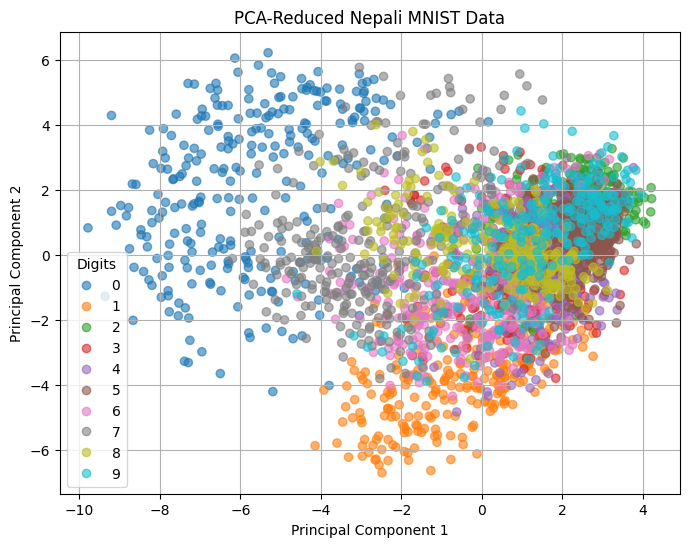

Training samples: 2304, Testing samples: 576
Classification Accuracy on PCA-reduced data: 42.88%


/Users/sahajrajmalla/Documents/nepali-quantum-mnist/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


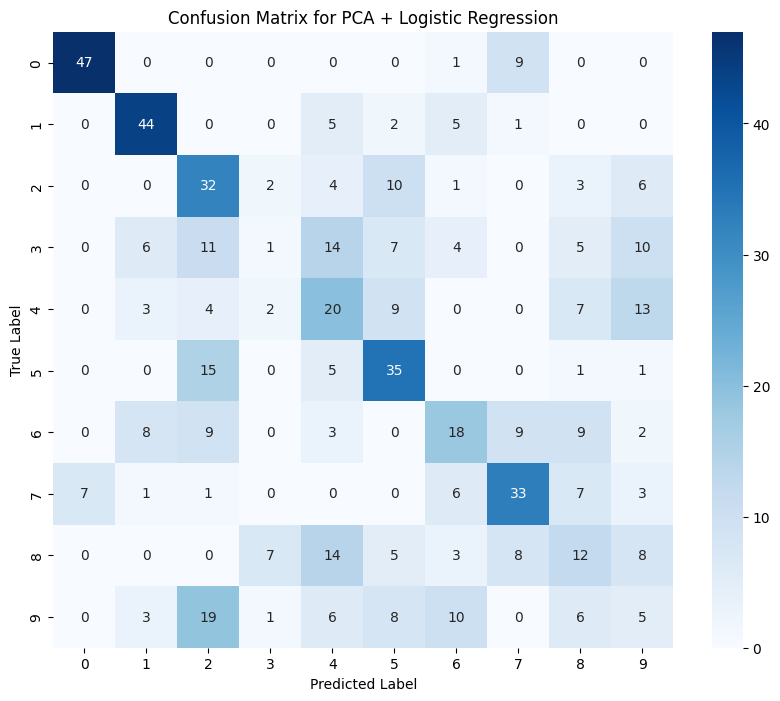

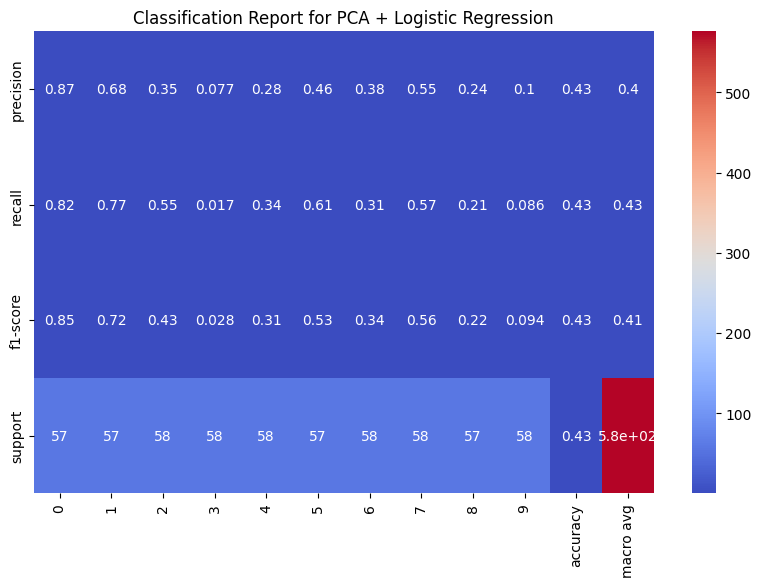

Small density matrix (before embedding):
 [[0.59267581+0.j 0.05331126+0.j]
 [0.05331126+0.j 0.40732419+0.j]]


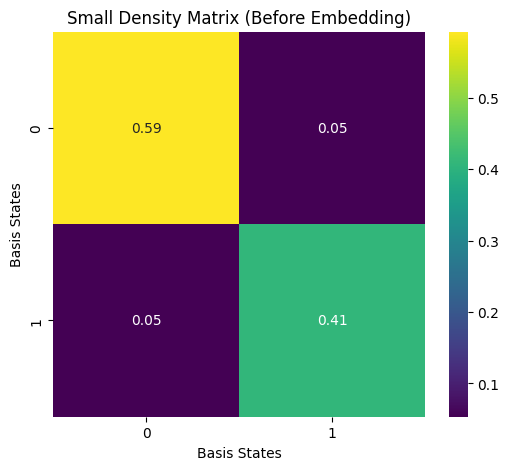

Density matrix matches the required size 2x2.


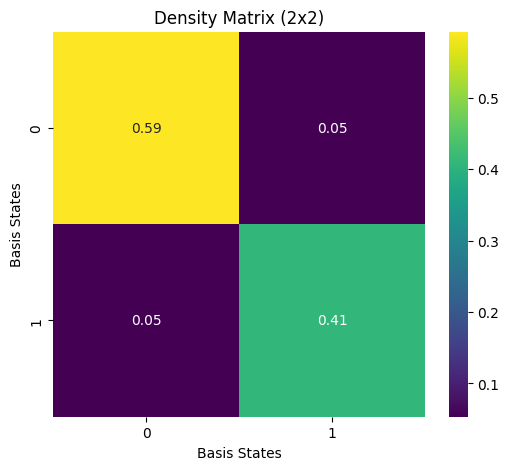

Diagonalization parameters: []
Approximate principal components from QPCA: [array(0.18535161)]


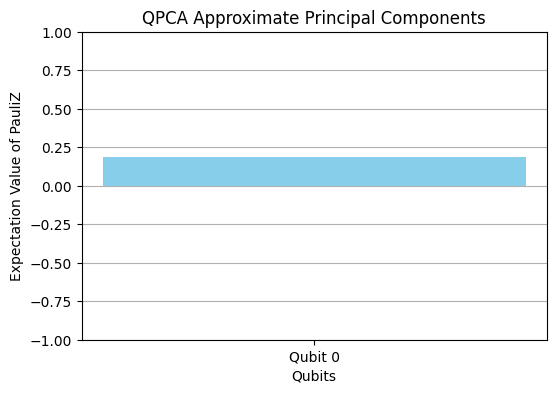

Classical PCA Eigenvalues: [0.60691537 0.39308463]
QPCA Approximate Principal Components: [array(0.18535161)]


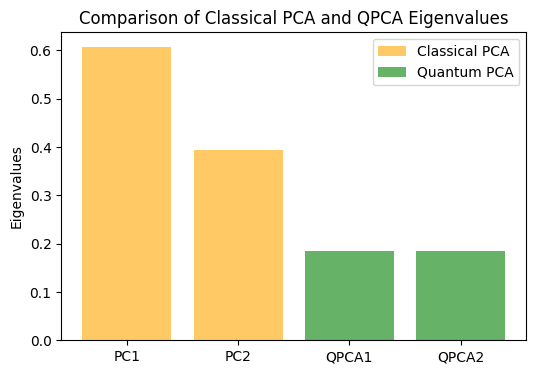

In [5]:
import os
import numpy as np
import pandas as pd
import pennylane as qml
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

###############################################################################
# 1. Nepali MNIST Dataset
###############################################################################
class NepaliMNISTDataset(Dataset):
    """
    Custom dataset for Nepali numerals. Assumes root directory structure:
      root_dir/
      ├── 0/
      │   ├── image1.png
      │   └── ...
      ├── 1/
      │   ├── image1.png
      │   └── ...
      └── 9/
          ├── image1.png
          └── ...
    """
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.data_paths = []
        self.labels = []

        # Scanning directory for digit folders
        for label_str in sorted(os.listdir(root_dir)):
            label_path = os.path.join(root_dir, label_str)
            if not os.path.isdir(label_path):
                continue
            try:
                label = int(label_str)
            except ValueError:
                continue  # Skip non-integer directory names
            for img_name in os.listdir(label_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    self.data_paths.append(os.path.join(label_path, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        img_path = self.data_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('L')  # ensure grayscale
        if self.transform:
            img = self.transform(img)
        return img, label

###############################################################################
# 2. Data Loading and Preprocessing
###############################################################################
def load_nepali_data(root_dir, batch_size=32):
    # Basic transforms to resize to 28x28 and convert to tensor
    transform_pipeline = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    dataset = NepaliMNISTDataset(root_dir, transform=transform_pipeline)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return loader

def preprocess_data(loader, n_components=2):
    """
    Flattens images to vectors, applies PCA to reduce to n_components.
    Returns (data_pca, labels).
    """
    flattened_data = []
    labels = []
    for images, lbls in loader:
        # Ensure tensors are on CPU before converting to NumPy
        images = images.cpu()
        flattened_batch = images.view(images.size(0), -1).numpy()
        flattened_data.append(flattened_batch)
        labels.append(lbls.numpy())

    data_array = np.concatenate(flattened_data, axis=0)
    labels_array = np.concatenate(labels, axis=0)
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_array)
    return data_pca, labels_array  # shape: (num_samples, n_components), (num_samples,)

###############################################################################
# 3. Build a Density Matrix from Classical Vectors
###############################################################################
def build_density_matrix(classical_data):
    """
    Creates a density matrix by averaging the outer products of normalized vectors.
    classical_data: (num_samples, n_components)
    Returns a (n_components, n_components) density matrix.
    """
    n_samples, dim = classical_data.shape
    rho = np.zeros((dim, dim), dtype=np.complex128)
    for vec in classical_data:
        norm = np.linalg.norm(vec)
        if norm == 0:
            continue  # Skip zero vectors to avoid division by zero
        norm_vec = vec / norm
        outer_prod = np.outer(norm_vec, norm_vec.conj())
        rho += outer_prod
    rho /= n_samples
    return rho

###############################################################################
# 4. Quantum PCA Circuit with PennyLane
###############################################################################
# Set n_qubits based on n_components
n_components = 2  # You can adjust this as needed (e.g., 4 for 2 qubits)
n_qubits = int(np.ceil(np.log2(n_components)))  # Minimum qubits to represent n_components

dev = qml.device("default.mixed", wires=n_qubits)

def load_density_matrix(rho):
    """
    Loads a small (2^n × 2^n) density matrix 'rho' onto the 'default.mixed' simulator.
    """
    # Ensure rho is 2^n_qubits x 2^n_qubits
    dim = 2 ** n_qubits
    if rho.shape != (dim, dim):
        raise ValueError(f"Density matrix shape {rho.shape} does not match required shape {(dim, dim)} for {n_qubits} qubits.")
    qml.QubitDensityMatrix(rho, wires=range(n_qubits))

@qml.qnode(dev)
def qpca_circuit(rho_matrix, diag_params):
    """
    Illustrative QPCA circuit:
      1. Load a density matrix 'rho_matrix'.
      2. Apply parameterized gates that attempt to diagonalize the state.
      3. Measure PauliZ to approximate eigenvalues (principal components).
    """
    load_density_matrix(rho_matrix)

    # Simple attempt at diagonalization: parametric controlled rotations
    for i in range(n_qubits - 1):
        qml.CRX(diag_params[i], wires=[i, i+1])
        qml.CRZ(diag_params[i], wires=[i, i+1])

    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

###############################################################################
# 5. Visualization Functions
###############################################################################
def plot_pca_data(data_pca, labels):
    """
    Plots the PCA-reduced data in a 2D scatter plot.
    """
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.title("PCA-Reduced Nepali MNIST Data")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(*scatter.legend_elements(), title="Digits")
    plt.grid(True)
    plt.show()

def plot_density_matrix(rho, title="Density Matrix"):
    """
    Plots the density matrix as a heatmap.
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(np.abs(rho), annot=True, fmt=".2f", cmap='viridis')
    plt.title(title)
    plt.xlabel("Basis States")
    plt.ylabel("Basis States")
    plt.show()

def plot_qpca_results(results, title="QPCA Approximate Principal Components"):
    """
    Plots the QPCA results as a bar chart.
    """
    plt.figure(figsize=(6, 4))
    qubit_indices = [f"Qubit {i}" for i in range(len(results))]
    plt.bar(qubit_indices, results, color='skyblue')
    plt.title(title)
    plt.xlabel("Qubits")
    plt.ylabel("Expectation Value of PauliZ")
    plt.ylim([-1, 1])
    plt.grid(axis='y')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Plots a confusion matrix to visualize classifier performance.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def plot_classification_report(y_true, y_pred, title="Classification Report"):
    """
    Prints and visualizes the classification report.
    """
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.iloc[:-1, :].T, annot=True, cmap='coolwarm')
    plt.title(title)
    plt.show()

###############################################################################
# 6. Main Function to Demonstrate QPCA with Visualizations and Accuracy Metrics
###############################################################################
def main():
    import pandas as pd  # Import here to avoid issues if not used elsewhere
    # Update the root_dir to your dataset path
    root_dir = "/Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals" # <-- Replace with your actual dataset path
    loader = load_nepali_data(root_dir, batch_size=32)

    # Reduce to n_components for qubit demonstration
    data_pca, labels = preprocess_data(loader, n_components=n_components)
    print("PCA-reduced data shape:", data_pca.shape)

    # Visualize PCA-Reduced Data
    plot_pca_data(data_pca, labels)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        data_pca, labels, test_size=0.2, random_state=42, stratify=labels
    )
    print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

    # Train a classifier on PCA-reduced data
    clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Compute and print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classification Accuracy on PCA-reduced data: {accuracy * 100:.2f}%")

    # Plot Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix for PCA + Logistic Regression")

    # Plot Classification Report
    plot_classification_report(y_test, y_pred, title="Classification Report for PCA + Logistic Regression")

    # Check if n_components is a power of 2
    if not (n_qubits >= 1 and 2**n_qubits >= n_components):
        raise ValueError(f"Number of qubits {n_qubits} is insufficient for n_components={n_components}.")

    # Build a density matrix from the classical PCA vectors
    small_rho = build_density_matrix(data_pca)
    print("Small density matrix (before embedding):\n", small_rho)

    # Visualize the Density Matrix
    plot_density_matrix(small_rho, title="Small Density Matrix (Before Embedding)")

    # If n_qubits > log2(n_components), embed small_rho into a larger density matrix
    dim = 2 ** n_qubits
    if small_rho.shape[0] < dim:
        # Initialize a larger density matrix with zeros
        big_rho = np.zeros((dim, dim), dtype=np.complex128)
        # Place the small_rho in the top-left corner
        big_rho[:small_rho.shape[0], :small_rho.shape[1]] = small_rho
        # Ensure the trace is 1 by normalizing
        trace = np.trace(big_rho)
        if trace != 0:
            big_rho /= trace
        print(f"Embedded density matrix (size {dim}x{dim}):\n", big_rho)
        # Visualize the Embedded Density Matrix
        plot_density_matrix(big_rho, title=f"Embedded Density Matrix ({dim}x{dim})")
    else:
        big_rho = small_rho
        print(f"Density matrix matches the required size {dim}x{dim}.")
        plot_density_matrix(big_rho, title=f"Density Matrix ({dim}x{dim})")

    # Randomly initialize diagonalization parameters
    diag_params = np.random.uniform(0, np.pi, size=(n_qubits - 1,))
    print("Diagonalization parameters:", diag_params)

    # Execute QPCA circuit
    results = qpca_circuit(big_rho, diag_params)
    print("Approximate principal components from QPCA:", results)

    # Visualize QPCA Results
    plot_qpca_results(results)

    # (Optional) Compare QPCA results with classical PCA
    # Since QPCA in this illustrative example is simplistic, for a meaningful comparison,
    # an optimization routine should be implemented to align QPCA with classical PCA.

    # For demonstration, let's assume QPCA aims to recover the eigenvalues of the density matrix
    eigenvalues, _ = np.linalg.eigh(small_rho)
    eigenvalues_sorted = np.sort(eigenvalues)[::-1]  # Sort in descending order
    print("Classical PCA Eigenvalues:", eigenvalues_sorted)
    print("QPCA Approximate Principal Components:", results)

    # Plot comparison of classical PCA and QPCA eigenvalues
    plt.figure(figsize=(6, 4))
    plt.bar(['PC1', 'PC2'], eigenvalues_sorted[:2], alpha=0.6, label='Classical PCA', color='orange')
    plt.bar(['QPCA1', 'QPCA2'], results, alpha=0.6, label='Quantum PCA', color='green')
    plt.title("Comparison of Classical PCA and QPCA Eigenvalues")
    plt.ylabel("Eigenvalues")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
